## Variational autoencoder - CelebA

In [1]:
%matplotlib inline

import torch, torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid
from torchvision import datasets, transforms

from torch.utils.data import Dataset, DataLoader
from PIL import Image

device = torch.device("cuda:1")

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [3]:
lr = 0.001
z_dim = 512

In [4]:
class CelebaDataset(Dataset):

    def __init__(self, root_dir, im_name_list, resize_dim, transform=None):
        self.root_dir = root_dir
        self.im_list = im_name_list
        self.resize_dim = resize_dim
        self.transform = transform

    def __len__(self):
        return len(self.im_list)

    def __getitem__(self, idx):
        im = Image.open(os.path.join(self.root_dir, self.im_list[idx]))        

        if self.transform:
            im = self.transform(im)

        return im

In [5]:
root_dir = "./img_align_celeba/"
image_files = os.listdir(root_dir)
print(image_files[0])

071051.jpg


In [6]:
trans = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

train_dataset = CelebaDataset(root_dir, image_files[:180000], (128, 128), transform=trans)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

valid_dataset = CelebaDataset(root_dir, image_files[180000:190000], (128, 128), transform=trans)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True)

In [7]:
for x,y in enumerate(train_loader):
    print(np.shape(y))
    break

torch.Size([64, 3, 128, 128])


In [8]:
class Conv_Block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=(3,3), padding=1, stride=1, pool_kernel_size=(2, 2)):
        super(Conv_Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding, stride)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding, stride)
        self.pool = nn.MaxPool2d(pool_kernel_size)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        return x

In [9]:
class Encoder(nn.Module):
    """ 
    outputs are the mean, std of the latent variable z.
    """
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.block1 = Conv_Block(3, 64)
        self.block2 = Conv_Block(64, 128)  
        self.block3 = Conv_Block(128, 256)
        self.block4 = Conv_Block(256, 32)
        self.linear1 = nn.Linear(2048, 512)
        self.mu_fc = nn.Linear(512, z_dim)
        self.log_var_fc = nn.Linear(512, z_dim)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = torch.flatten(x, start_dim=1)        
        x = F.relu(self.linear1(x))              
        mu, log_var = self.mu_fc(x), self.log_var_fc(x)
        
        return mu, log_var

In [10]:
class Decoder(nn.Module):
    """ 
    Input is a reparametrized latent representation.
    """
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.fc1 = nn.Linear(z_dim, 512)
        self.fc2 = nn.Linear(512, 2048)

        self.decode_layer = nn.Sequential(
            nn.Conv2d(32, 64, (3, 3), padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # 16x16
            nn.Conv2d(64, 128, (3, 3), padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # 32x32
            nn.Conv2d(128, 64, (3, 3), padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # 64x64
            nn.Conv2d(64, 32, (3, 3), padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # 128x128
            nn.Conv2d(32, 3, (3, 3), padding=1),
            nn.Sigmoid(),
        )        

    def forward(self, z):
        x = F.relu(self.fc1(z))
        x = self.fc2(x)
        x = x.view(-1, 32, 8, 8)
        x = self.decode_layer(x)
        
        return x

In [11]:
class VAE(nn.Module):
    
    def __init__(self):
        super(VAE, self).__init__()
        self.__dict__.update(locals())
        self.encoder = Encoder().to(device)
        self.decoder = Decoder().to(device)

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        out_img = self.decoder(z)

        return out_img, mu, log_var

    def reparameterize(self, mu, log_var):
        """" Reparametrization trick: z = mean + std*epsilon,
             where epsilon ~ N(0, 1).
        """
        epsilon = torch.randn(mu.shape).to(device)
        z = mu + epsilon * torch.exp(log_var/2) # 2 for convert var to std
        return z

In [12]:
model = VAE().to(device)

In [13]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [14]:
def show(img):
    npimg = img.detach().cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

In [15]:
def reconstruct_images(model, images, save=False):
    batch = images[:9]
    reconst_images, _, _ = model(batch)
    img = make_grid(reconst_images, nrow=int(reconst_images.shape[0]**0.5))    
    show(img)

In [16]:
def sample_images(num_images=9, save=False):
    # Random sample z
    z = torch.randn(num_images, z_dim).to(device)    
    sample = model.decoder(z)

    img = make_grid(sample, nrow=int(num_images**0.5))    
    show(img)

In [17]:
def sample_interpolated_images():

    # Sample latent vectors
    z1 = torch.normal(torch.zeros(z_dim), 1)
    z2 = torch.normal(torch.zeros(z_dim), 1)        
    num_imgs = 10
    samples = torch.zeros((num_imgs, 3, 128, 128))
    
    # Interpolate within latent vectors
    for idx, alpha in enumerate(np.linspace(0, 1, 10)):
        z = (alpha*z1 + (1-alpha)*z2).to(device)
        sample = model.decoder(z)
        samples[idx] = sample
    img = make_grid(samples, nrow=num_imgs)
    show(img)

In [18]:
def valid_loss():
    model.eval()
    num_batch = len(valid_loader)
    total_loss = 0
    for img in valid_loader:
        img = img.to(device)
        out_img, mu, log_var = model(img)
        recon_loss = torch.sum((img-out_img)**2)
        kl_divergence = torch.sum(0.5*(mu**2 + torch.exp(log_var)-log_var-1))
        
        loss = recon_loss + kl_divergence
        total_loss+=loss.item()
    
    return total_loss/num_batch

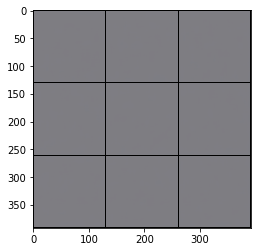

epoch:0, itr:0, loss:296957.46875


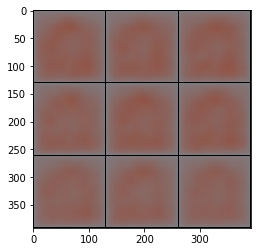

epoch:0, itr:25, loss:285575.25


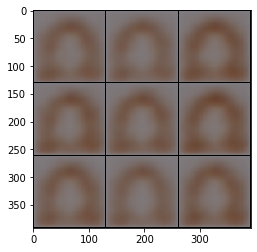

epoch:0, itr:50, loss:252052.40625


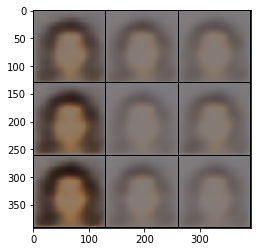

epoch:0, itr:75, loss:271424.875


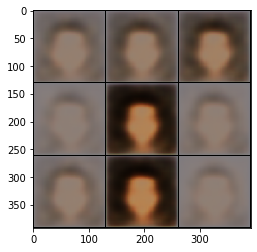

epoch:0, itr:100, loss:220818.703125


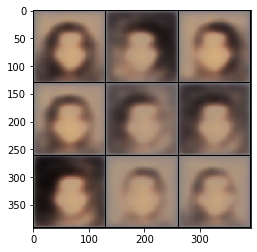

epoch:0, itr:125, loss:177820.671875


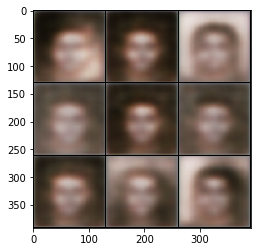

epoch:0, itr:150, loss:139605.125


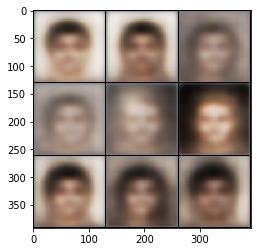

epoch:0, itr:175, loss:129629.7109375


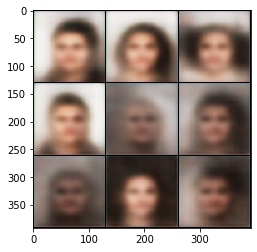

epoch:0, itr:300, loss:110780.2109375


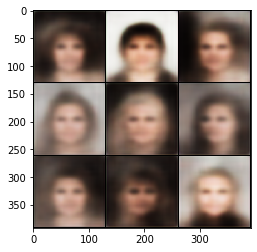

epoch:0, itr:600, loss:85015.0234375


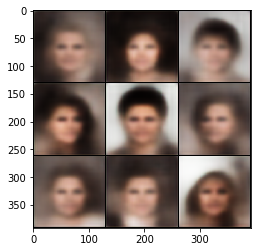

epoch:0, itr:900, loss:85114.7109375


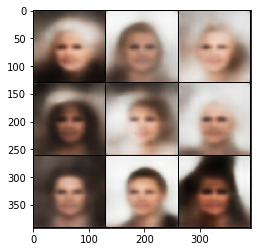

epoch:0, itr:1200, loss:79412.171875


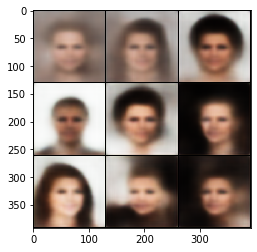

epoch:0, itr:1500, loss:72188.3671875


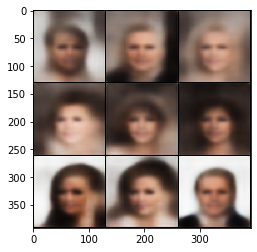

epoch:0, itr:1800, loss:74309.2109375
epoch:0, train loss:31967.5, valid loss:65410.599547173566
epoch:1, train loss:27698.23046875, valid loss:54617.16608404658
epoch:2, train loss:25421.03515625, valid loss:48942.36418317078
epoch:3, train loss:21692.48046875, valid loss:45924.57874079419
epoch:4, train loss:22432.322265625, valid loss:43218.50152393511


In [19]:
for epoch in range(5):
    model.train()
    best_valid = np.inf

    for itr, img in enumerate(train_loader):
        
        img = img.to(device)
        out_img, mu, log_var = model(img)
        
        recon_loss = torch.sum((img-out_img)**2)
        kl_divergence = torch.sum(0.5*(mu**2 + torch.exp(log_var)-log_var-1))
        
        loss = recon_loss + kl_divergence
        
        optimizer.zero_grad()                
        loss.backward()
        optimizer.step()
        
        if itr<200 and epoch==0:
            print_interval = 25
        elif itr>=200 and epoch==0:
            print_interval = 300
        
        if itr%print_interval==0 and itr<2000 and epoch==0:
            reconstruct_images(model, img)
            print('epoch:{}, itr:{}, loss:{}'.format(epoch, itr, loss.item()))
    
    loss_valid = valid_loss()
    print('epoch:{}, train loss:{}, valid loss:{}'.format(epoch, loss.item(), loss_valid))
    
    if loss_valid < best_valid:
        torch.save(model.state_dict(), './saves/vae_celeba.pth')
        best_valid = loss_valid

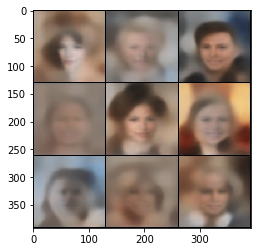

In [40]:
sample_images()

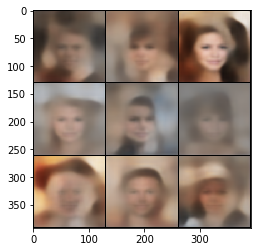

In [44]:
sample_images()

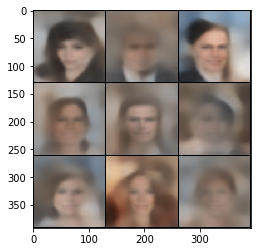

In [46]:
sample_images()

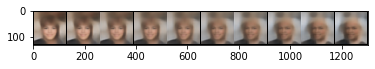

In [49]:
sample_interpolated_images()

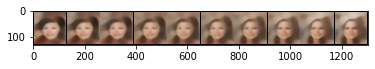

In [51]:
sample_interpolated_images()